<a href="https://colab.research.google.com/github/jeffbgreene/geology-558/blob/main/Supervised_Classification_of_Lunar_Minerals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Classification of Lunar Minerals
#### Author: Jeff Greene
#### Date : 1/31/2025

### **Lunar Sample Data Set Description**

The data utilized in this notebook was retrieved from the website [Astromat](https://search.astromat.org/?eventId=3407). The data is a summary of chemical analysis performed on returned samples from Apollo 11, 12, 14, 15, 16 and 17. For reference, I have included a visual representation of the landing locations of each of the Apollo missions.



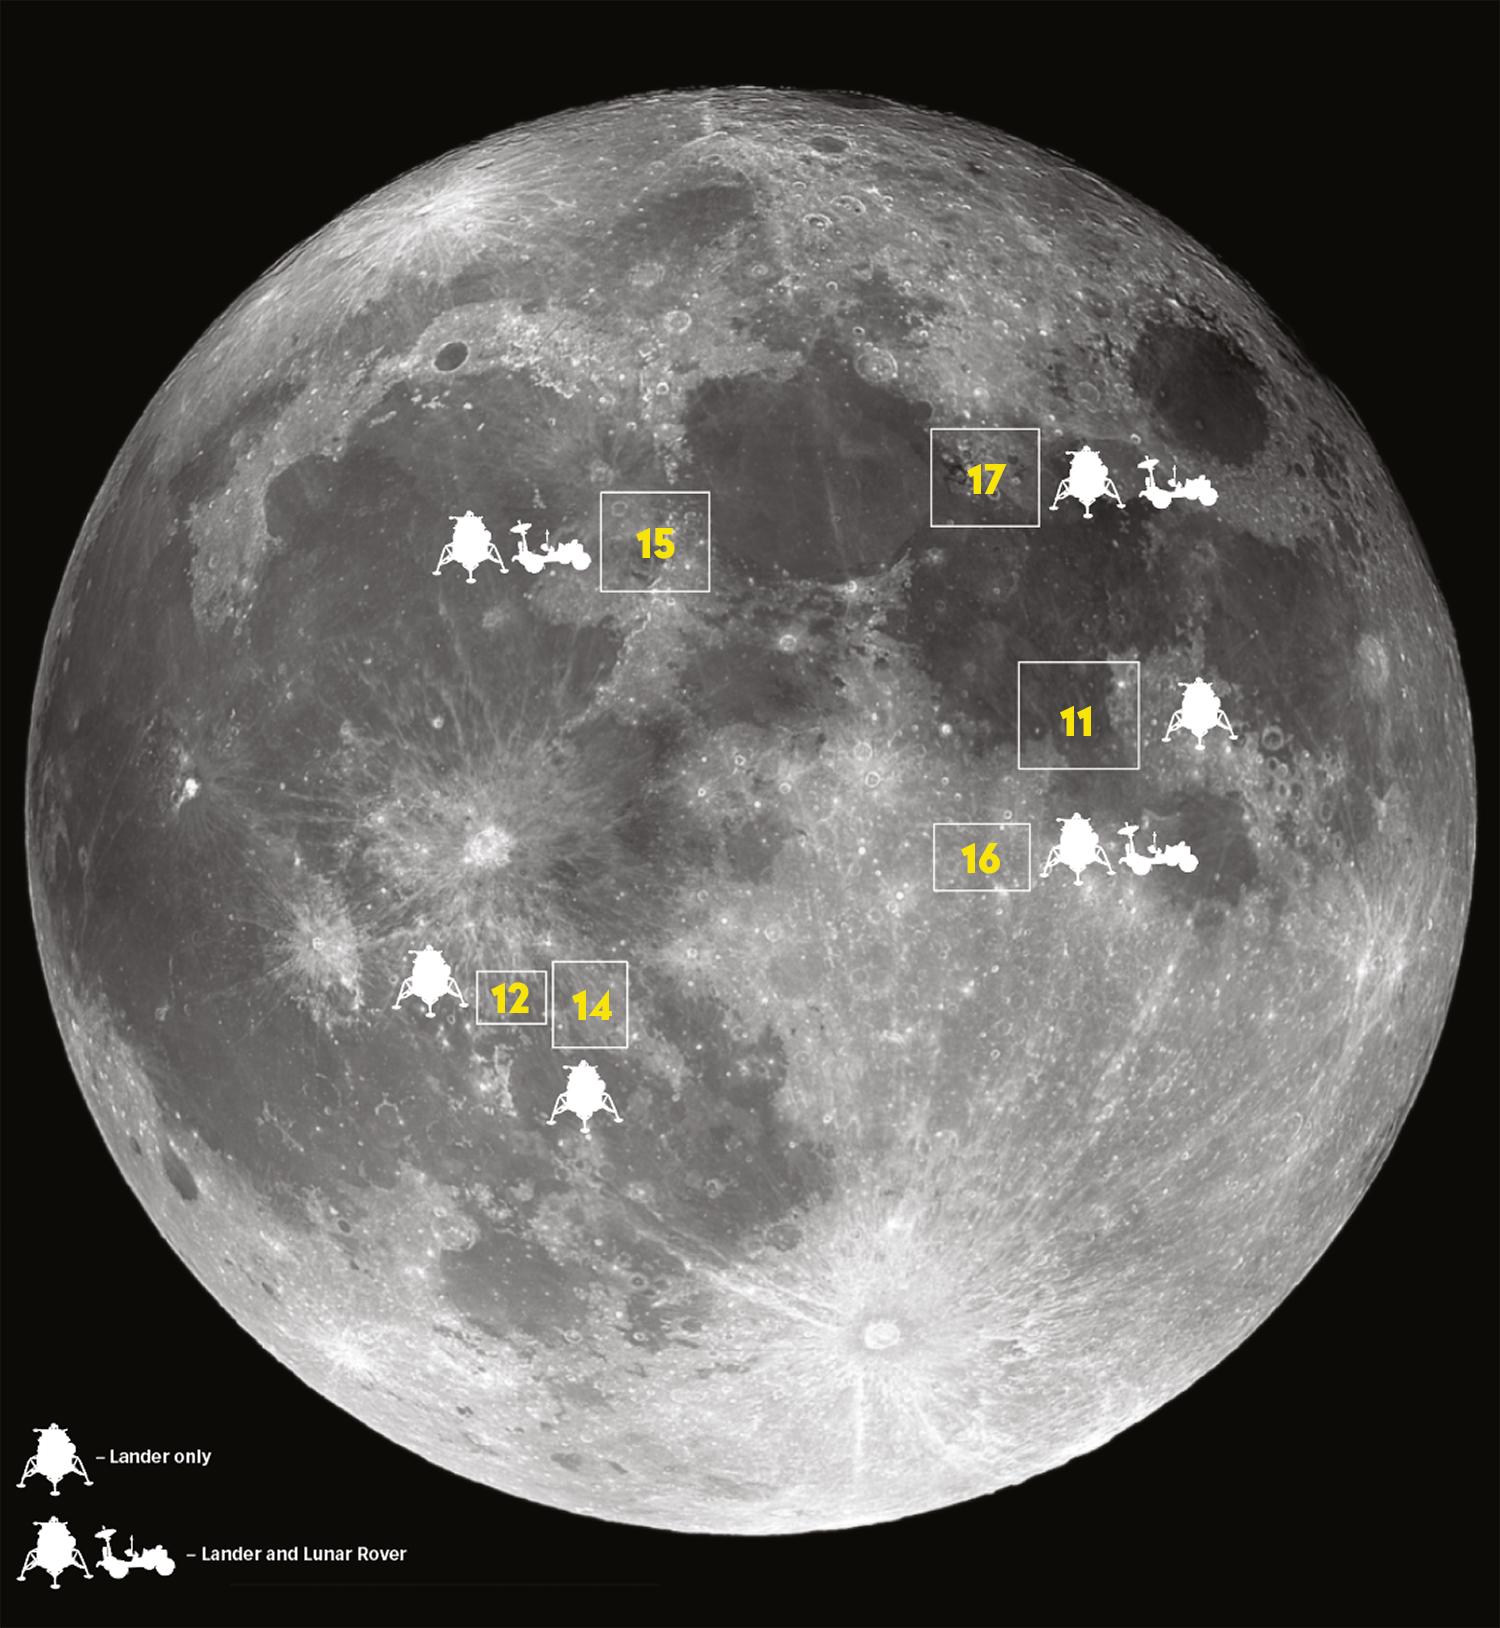



### <p style="text-align:center;"><i>Figure 1: Apollo Landing sites where Lunar samples were collected.</i></p>

### Imports

In [1]:
# Pip install this libray on the first run
!pip install -U mpltern

# For preprocessing labels and splitting the data
# XGBoost and SciKit learn had a strange interaction, so I needed to add this code. This is described on
# Stack Overflow "Scikit-learn version 1.6 modified the API around its "tags", and that's the cause of this error.""
# https://stackoverflow.com/questions/79290968/super-object-has-no-attribute-sklearn-tags
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# To standardize the features
from sklearn.preprocessing import StandardScaler, label_binarize

from sklearn.metrics import accuracy_score, log_loss

# Logistic Regression
from sklearn.linear_model import LogisticRegression

import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# Stats Libs
import scipy.stats as stats
from scipy.stats import pearsonr

# XGBoost
import xgboost as xgb

# Libraries for the NN
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical

import mpltern

## Confusion matrix and other metrics libs
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, classification_report

# ROC Curves
from sklearn.metrics import roc_curve, auc


Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
  Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)


### Plotting function definitions

---




In [2]:
# Define a function for the confusion matrix
def plot_confusion_matrix(y_test, y_pred, algorithm_type):
  # Set the figure size
  plt.rcParams["figure.figsize"] = (20,20)
  # Set the default font size
  plt.rcParams.update({'font.size': 12})

  cm = confusion_matrix(y_test, y_pred)
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized,
                                display_labels=classes)
  disp.plot()
  plt.title(f'Normalized Confusion Matrix for {algorithm_type} algorithm')
  plt.grid(False)
  plt.show()

In [3]:
def plot_roc_curve(y_test_bin, y_pred_proba, algorithm_type):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(len(classes)):
      fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Plot the ROC curves
  plt.figure()
  for i in range(len(classes)):
      plt.plot(fpr[i], tpr[i], lw=2,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(classes[i], roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Multiclass ROC Curve for {algorithm_type}')
  plt.legend(loc="lower right")
  plt.show()


In [4]:
# Define function to display metrics and Classification Report
def display_metrics(y_test, y_pred, classes, algorithm_type):
  print(f'\n-------------------- {algorithm_type} Key Metrics --------------------')
  print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
  print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

  print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
  print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
  print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

  print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
  print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
  print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

  print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
  print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
  print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

  print(f'\n--------------- {algorithm_type} Classification Report ---------------\n')
  print(classification_report(y_test, y_pred, target_names=classes))

## Exploratory Data Analysis

---


The original data consists of assorted caterogorical and numerical features. Numeric values for chemical compositions in the data were derived with techniques including electron probe micro-analyzer (EMPA), although there were a variety of other techniques that were applied depending on what lab was performing the analysis.

During EDA I reduced the features in the dataset down to the 8 shown below and saved that filtered and cleaned data set to a CSV for use in this notebook. **For an in-depth look at the EDA**, please see this notebook: https://github.com/jeffbgreene/geology-558/blob/main/Supervised_Classification_EDA.ipynb

The **goal** of this notebook is to use the weight percentages of 8 different oxides as features and build models to predict the mineral type of samples. The models were created using Logistic Regression, XGBoost and a  multi-layer perceptron or feed-foward artificial neural network.

The **features** utilized are: FeO, CaO, MgO, Al2O3, TiO2, Cr2O3, MnO, Na2O

The **classes** are: APATITE, CLINOPYROXENE, FELDSPAR, GLASS, ILMENITE, INDETERMINATE, OLIVINE, PLAGIOCLASE, PYROXENE, SPINEL and SULFIDE

Since I am not a geologist by trade and don't really have any background in geology other than the class I took last semester and this class, I didn't really realize that some of the minerals in my data set are subtypes of others and discovered this by analyzing the misclassification seen in the confusion matrices for each model type. These issues will be discussed later on in the notebook. I will address the misclassification in my final submission, possibly by relabeling the samples that are subtypes of another mineral.


In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/jeffbgreene/geology-558/main/cleaned_lunar_data.csv', index_col=None, header=0)

In [6]:
df.head()

,FeO,CaO,MgO,Al2O3,TiO2,Cr2O3,MnO,Na2O,Mineral
0,40.70,0.210000,4.26,0.18,53.20,0.90,0.45,0.030027,ILMENITE
1,39.30,0.341816,4.55,0.00,54.60,1.03,0.33,0.030027,ILMENITE
2,38.20,0.341816,5.93,0.00,54.40,1.00,0.32,0.030027,ILMENITE
3,42.88,0.341816,2.04,0.07,53.58,1.08,0.40,0.030027,ILMENITE
4,45.02,0.341816,1.01,0.05,52.87,0.50,0.45,0.030027,ILMENITE


In [7]:
df.describe()

,FeO,CaO,MgO,Al2O3,TiO2,Cr2O3,MnO,Na2O
count,66709.000000,66709.000000,66709.000000,66709.000000,66709.000000,66709.000000,66709.000000,66709.000000
mean,19.943438,8.110508,18.048739,7.920414,3.312937,2.018260,1.443570,0.486538
std,15.900085,14.586996,16.638528,14.547902,13.889176,11.819894,49.890260,2.025587
min,0.000000,-0.220000,-0.030000,-0.070000,-0.020000,-0.140000,-0.010000,0.000000
25%,2.590000,0.330000,2.020000,0.530000,0.095108,0.076513,0.167942,0.042900
50%,19.600000,3.000000,16.373486,1.240000,0.770000,0.357805,0.382472,0.202151
75%,29.120000,15.480000,29.935900,5.780000,0.959606,0.590000,0.570000,0.400000
max,345.000000,1670.000000,318.000000,920.000000,1890.000000,1690.000000,5100.000000,170.000000


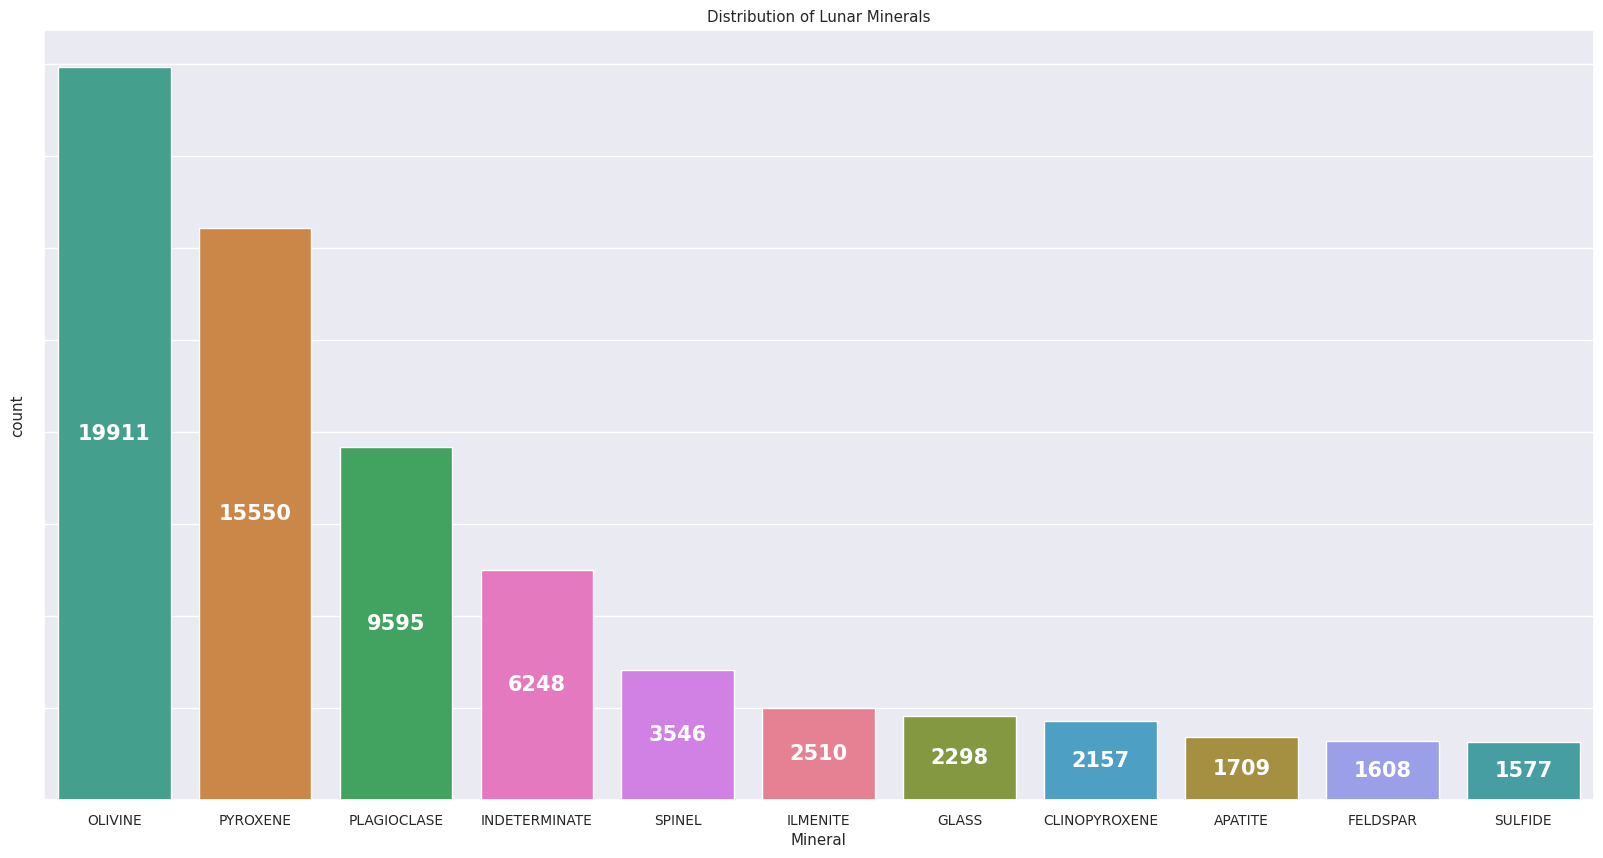

In [8]:
# Create a histogram to show mineral classes
sns.set_theme(rc={'figure.figsize':(20,10)})
sns.set(font_scale=.9)
ax = sns.countplot(x='Mineral', data=df, order=df['Mineral'].value_counts().index, hue='Mineral')
# Add count labels in the center of each bar
for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The height of the bar is the data value and can be used as the label
    label_text = f'{round(height)}'  # f'{height:.2f}' to format decimal values

    label_x = x + width / 2
    label_y = y + height / 2

    # Plot numric value of the stacked bar only when height is greater than specified value
    if height > 4.0:
        ax.text(label_x, label_y, label_text, color='w',
          weight='bold', ha='center', va='center', fontsize=15)


plt.title('Distribution of Lunar Minerals')
# Remove y-axis tick labels
ax.set_yticklabels([])
plt.show()

### <p style="text-align:center;"><i>Figure 2: Histogram distribution of 11 major mineral types in the Lunar samples.</i></p>

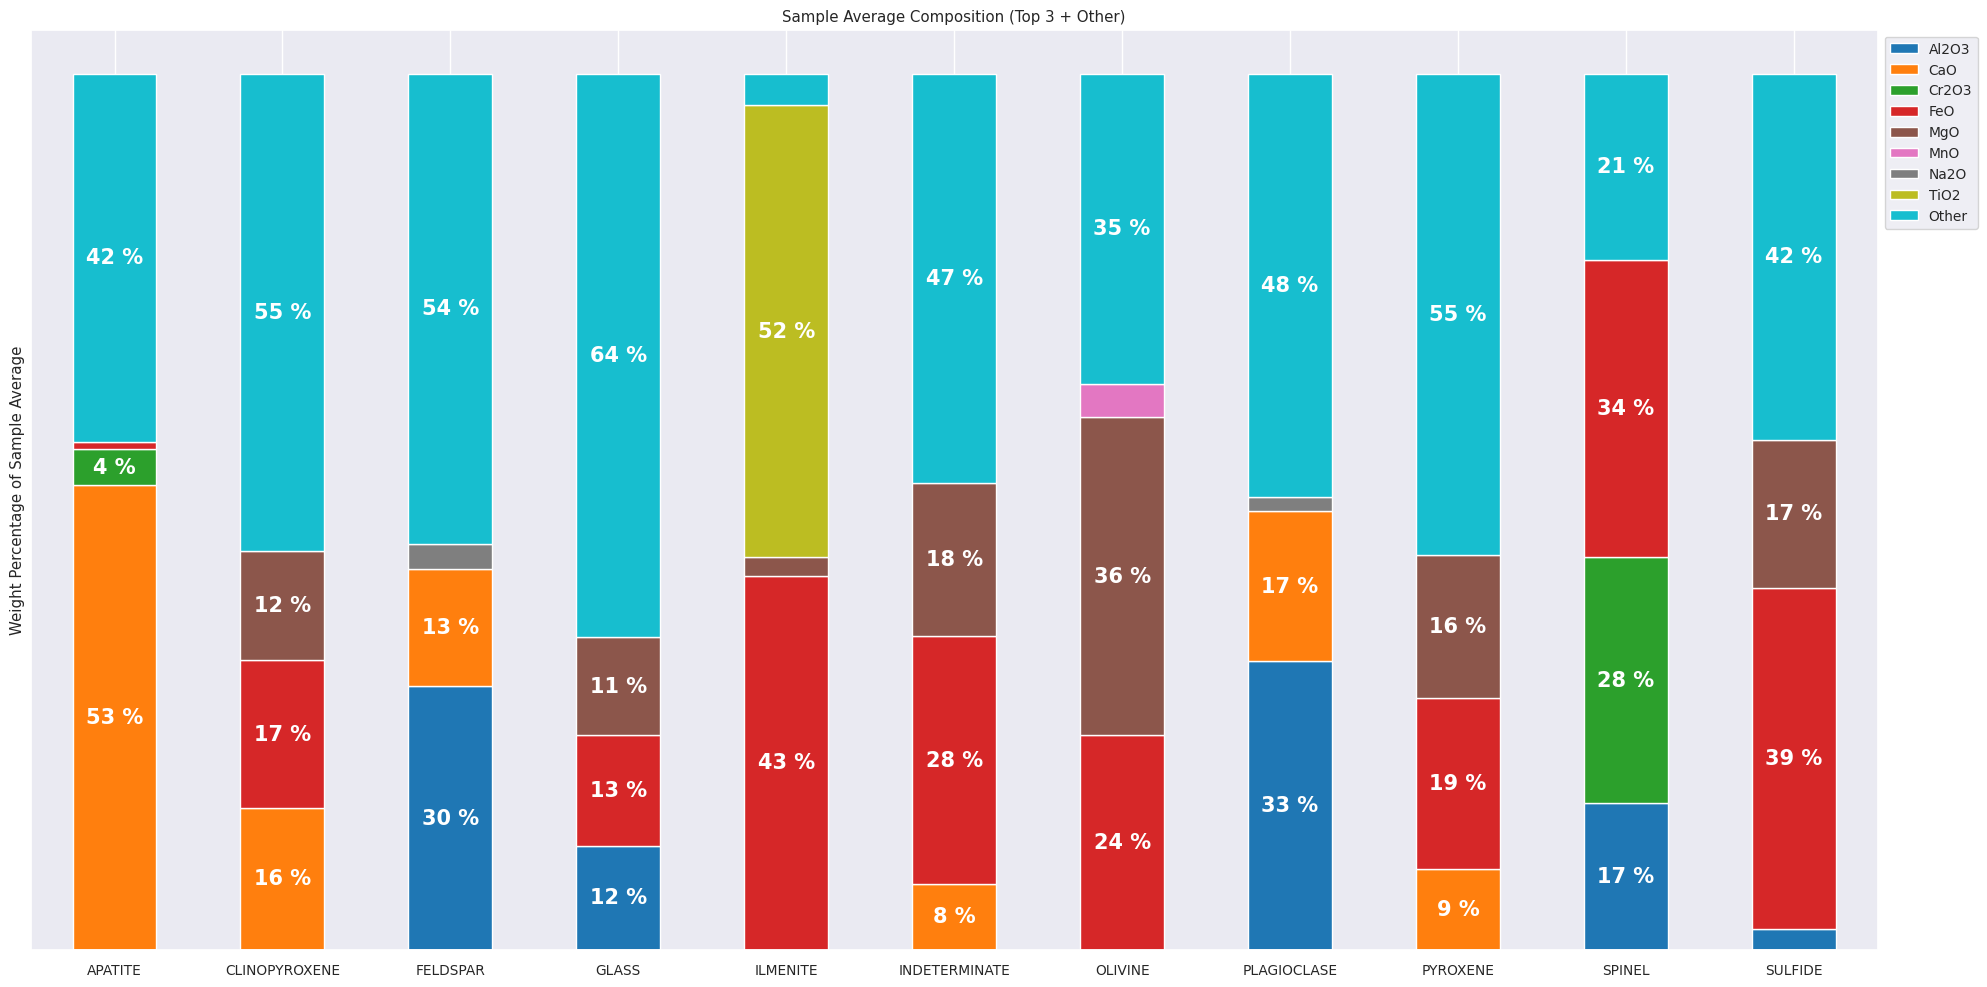

In [9]:
# Group the Samples by  mineral
# Calculate the average for the compound samples for each mineral group
grouped_df = df.groupby('Mineral', as_index=False).mean()
grouped_df.reset_index().rename(columns={df.index.name:'Mineral'})
grouped_df = grouped_df[grouped_df[['Mineral']].all(axis=1)]

# Step 1: Extract sample names some sums of row values can be performed
sample_names_op = grouped_df['Mineral']

df_compositions_op = grouped_df.drop(columns=['Mineral'])
def sum_rest(row, n_largest=3):
    largest = row.nlargest(n_largest)
    return 100 - largest.sum()

# Step 2: Get the top 3 largest values
df_top3_compositions_op = df_compositions_op.apply(lambda row: row.nlargest(3), axis=1)

# Step 3: Call the function defined above to remove the top 3 values and then return the percentage of other compounds and oxides
df_top3_compositions_op['Other'] = df_compositions_op.apply(sum_rest, axis=1)

# Step 4: Add back the 'Mineral' column
df_top3_compositions_op['Mineral'] = sample_names_op

# Step 5: Set 'Mineral' as index for plotting
df_top3_compositions_op = df_top3_compositions_op.set_index('Mineral')
# Step 6: Create the plot
# Create the subplots with two axes (one for each DataFrame)
fig, axes = plt.subplots()  # 1 row, 2 columns

# Stacked bar plot for compounds/oxides
df_top3_compositions_op.plot.bar(stacked=True, ax=axes, colormap='tab10')

for rect in axes.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The height of the bar is the data value and can be used as the label
    label_text = f'{round(height)} %'  # f'{height:.2f}' to format decimal values

    label_x = x + width / 2
    label_y = y + height / 2

    # Plot numric value of the stacked bar only when height is greater than specified value
    if height > 4.0:
        axes.text(label_x, label_y, label_text, color='w',
          weight='bold', ha='center', va='center', fontsize=15)

# Remove the y-ticks, as the numeric values are shown
plt.yticks([])
# Customize labels and titles for both subplots
axes.set_ylabel('Weight Percentage of Sample Average')
axes.set_title('Sample Average Composition (Top 3 + Other)')

# Customize x-axis labels to be each mineral name
axes.set_xlabel('')
axes.set_xticklabels(grouped_df.Mineral, rotation=0)

# relocate the legend
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Adjust the layout to fit everything
plt.tight_layout()


# Display the plot
plt.show()

### <p style="text-align:center;"><i>Figure 3: This stacked bar plot shows the major composition of the 11 major mineral groups in Lunar samples. These values are the average for all samples for a particular group.</i></p>

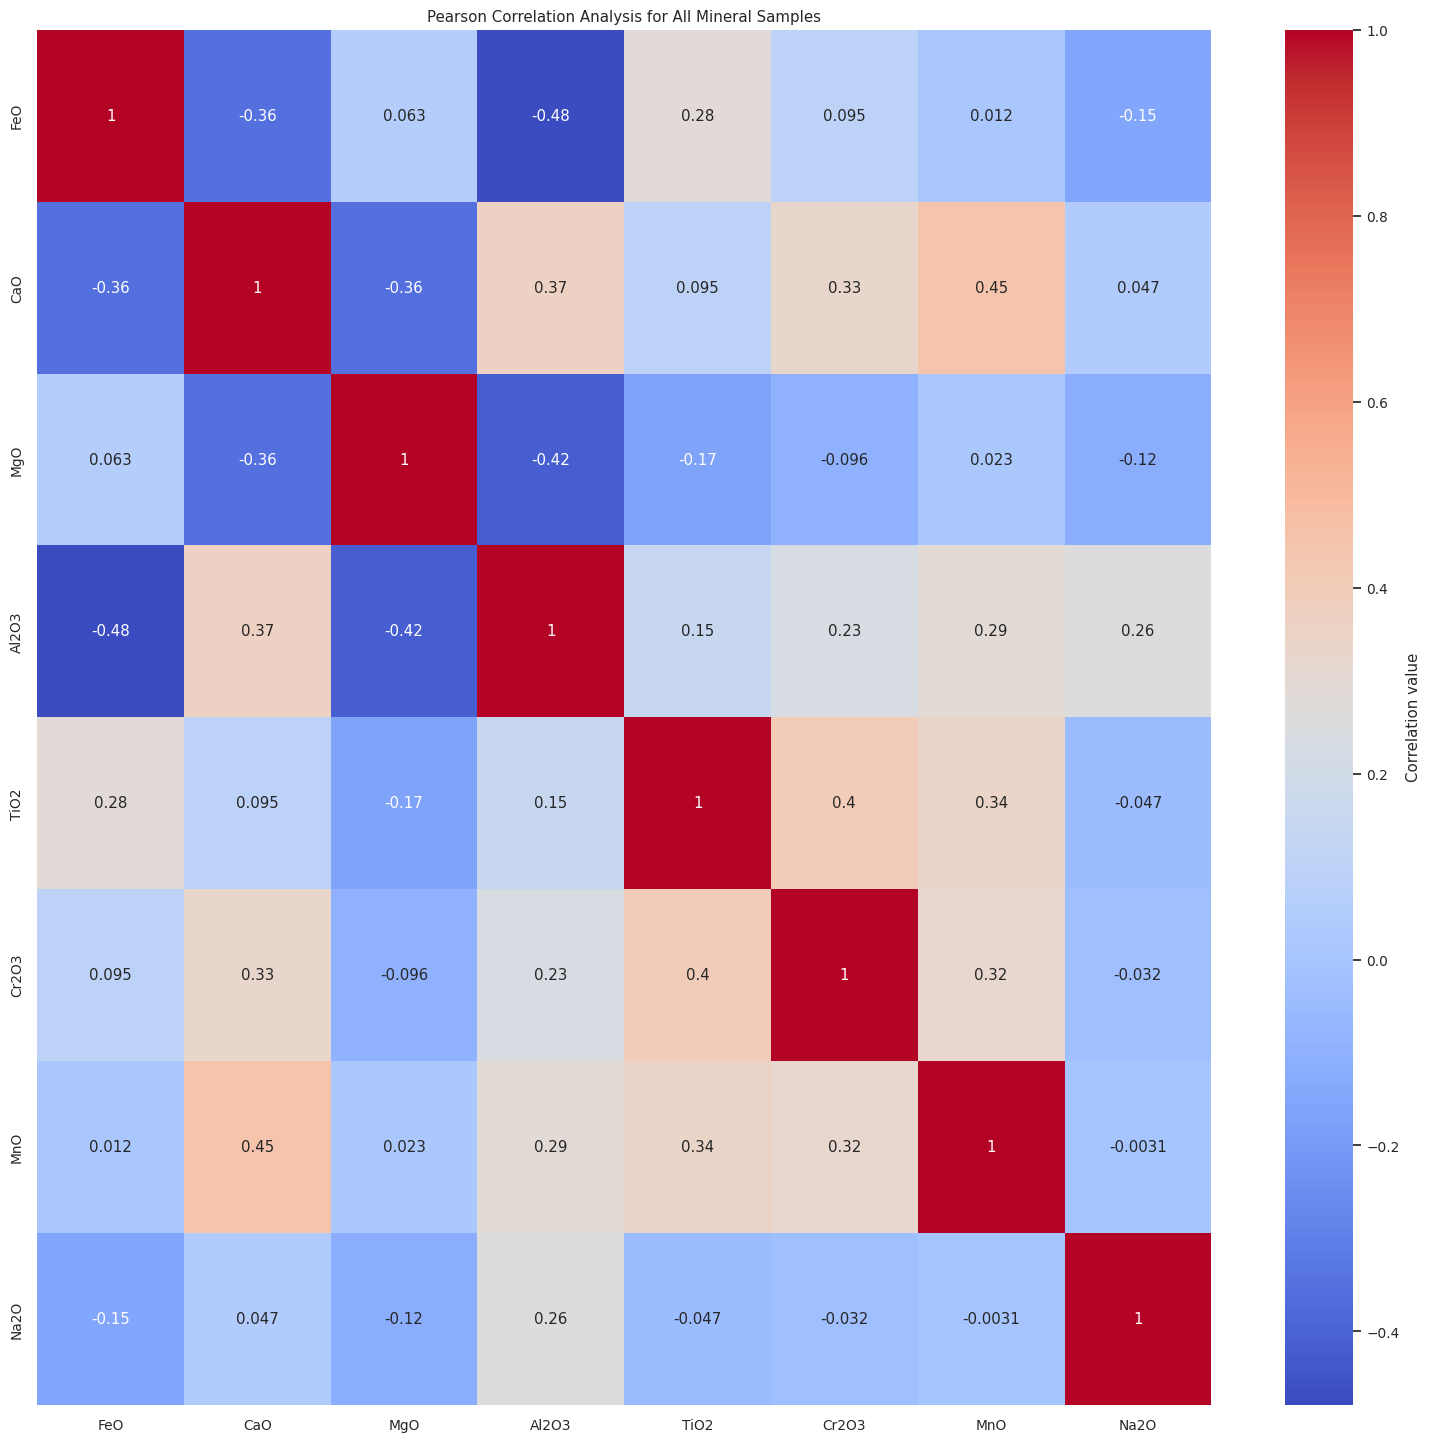

In [10]:
# Drop the Mineral column
df_rm = df.drop(['Mineral'], axis=1)

fig, ax = plt.subplots(figsize=[15, 15], sharex=True)

# Calculate the correlation matrix, dropping all NaN rows and columns
correlation_matrix = df_rm.corr(method='pearson').dropna(axis=0, how='all').dropna(axis=1, how='all')

# Plot the results of the correlation as a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlation value'})
plt.title("Pearson Correlation Analysis for All Mineral Samples")
ax.set_position([0.55, 0.1, 0.35, 0.8])  # Adjust position manually

plt.tight_layout()
plt.show()

### <p style="text-align:center;"><i>Figure 4: Interrelationships in all samples were assessed by Pearson correlation analysis. Multiple moderate correlations were observed.</i></p>

### Preprocessing


---

The mineral names cannot be used directly as the target for the various algorithms. Instead, the minerals names must be numerically encoded. I did this using the SciKit Learn LabelEncoder class. I also saved off the unique Mineral names as a list and dictionary if I needed to utilize them later

In [11]:
# Encode the Labels
le = preprocessing.LabelEncoder()
le.fit(df['Mineral'])
classes = le.classes_
class_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
df['Mineral']=le.transform(df['Mineral'])

# Sanity check to ensure that the Target classes were encoded properly
df.head()

,FeO,CaO,MgO,Al2O3,TiO2,Cr2O3,MnO,Na2O,Mineral
0,40.70,0.210000,4.26,0.18,53.20,0.90,0.45,0.030027,4
1,39.30,0.341816,4.55,0.00,54.60,1.03,0.33,0.030027,4
2,38.20,0.341816,5.93,0.00,54.40,1.00,0.32,0.030027,4
3,42.88,0.341816,2.04,0.07,53.58,1.08,0.40,0.030027,4
4,45.02,0.341816,1.01,0.05,52.87,0.50,0.45,0.030027,4


In [12]:
# Sanity check off the class list and dictionary I created in the previous cell
print(classes)
print(class_name_mapping)

['APATITE' 'CLINOPYROXENE' 'FELDSPAR' 'GLASS' 'ILMENITE' 'INDETERMINATE'
 'OLIVINE' 'PLAGIOCLASE' 'PYROXENE' 'SPINEL' 'SULFIDE']
{'APATITE': 0, 'CLINOPYROXENE': 1, 'FELDSPAR': 2, 'GLASS': 3, 'ILMENITE': 4, 'INDETERMINATE': 5, 'OLIVINE': 6, 'PLAGIOCLASE': 7, 'PYROXENE': 8, 'SPINEL': 9, 'SULFIDE': 10}


### Create the Feature and Target Vectors


---

In the next cell I set the variable X as the feature vectors to be utilized in the split step. The target variable is also set with the encoded numeric value for each mineral class. Because the neural network expects the encoded numeric value to be one-hot encoded, I performed that step here as well and saved those values in a different variable.

In [13]:
# Set the Feature Vectors
X = df.drop('Mineral', axis=1)
# Set the target variables
y = df['Mineral']

# One-hot encode target variables as that is the required input for the Neural Network
y_ohe = to_categorical(y, num_classes=len(classes)) # Assuming 10 classes

### Splitting the Data


---
Because of the class imbalance that can be see in the EDA above, I performed a Stratified Split on the data.


In [14]:
# Stratified split of train, test and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Create StratifiedShuffleSplit object
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# Perform stratified splitting
for train_index, val_index in stratified_splitter.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

Fit the training data with the scaler, and then transform the validation and test data to prevent bias

In [15]:
#Standardize the feature vectors
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Logistic Regression

---

I just used the basic Logistic Regression algorithm by fitting to the training set. I then used the test set for evaluation of the model

In [16]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

# Calculate training loss
y_train_pred = logreg.predict_proba(X_train)
train_loss = log_loss(y_train, y_train_pred)

# Calculate training accuracy
y_train_pred_labels = logreg.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred_labels)

print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)

Training Loss: 0.5147152231265147
Training Accuracy: 0.8686397121809148


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


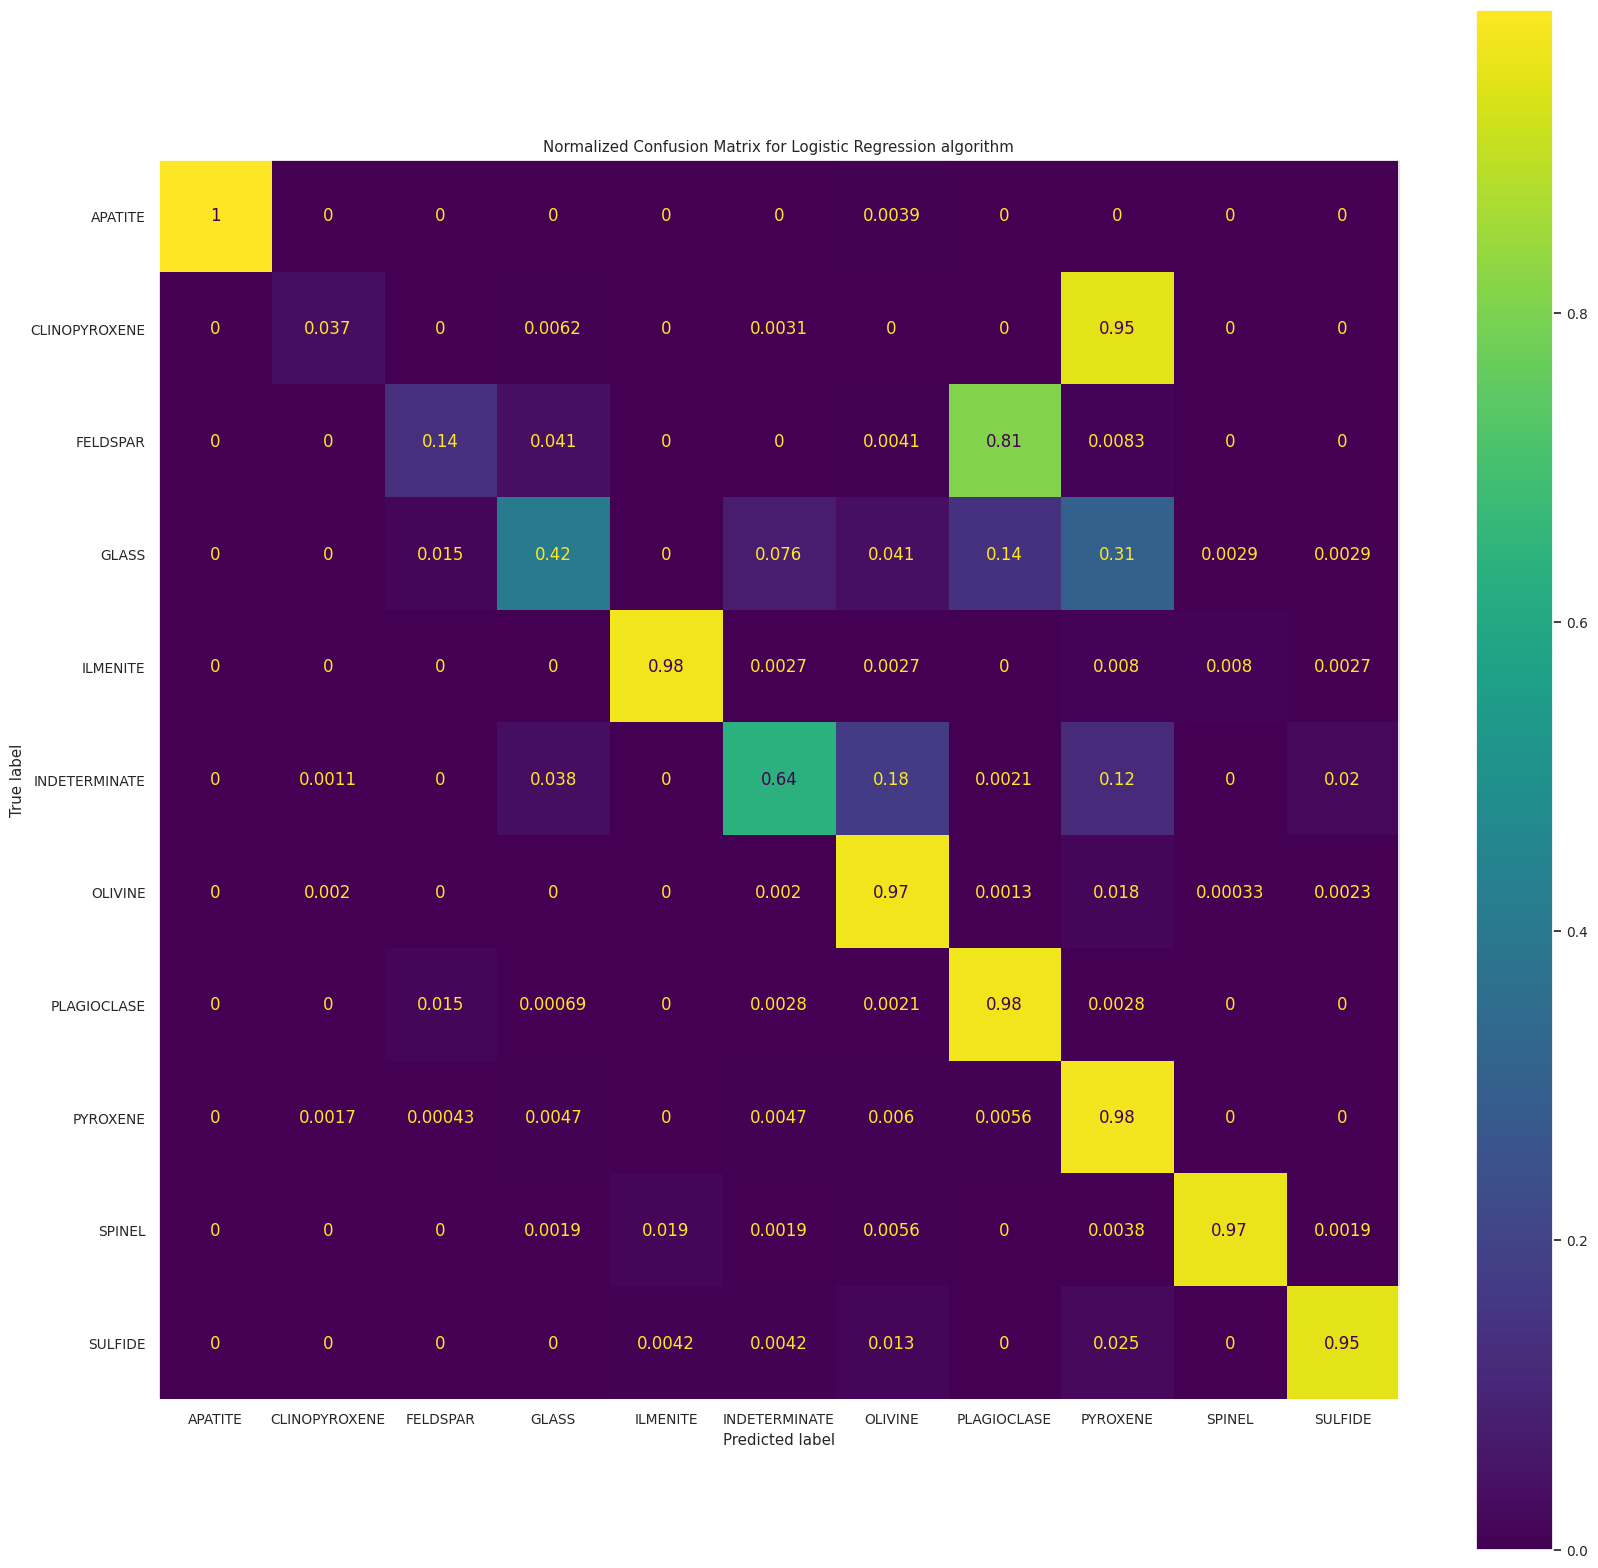

In [17]:
y_pred = logreg.predict(X_test)
plot_confusion_matrix(y_test, y_pred, 'Logistic Regression')

### <p style="text-align:center;"><i>Figure 5: The Confusion Matrix for Logistic Regression shows that the model is pretty accurate for most classes. However, almost all clinopyroxene samples were called pyroxene, which from a geology standpoint is accurate. I addressed how I will deal with this in the questions at the end of this notebook.</i></p>

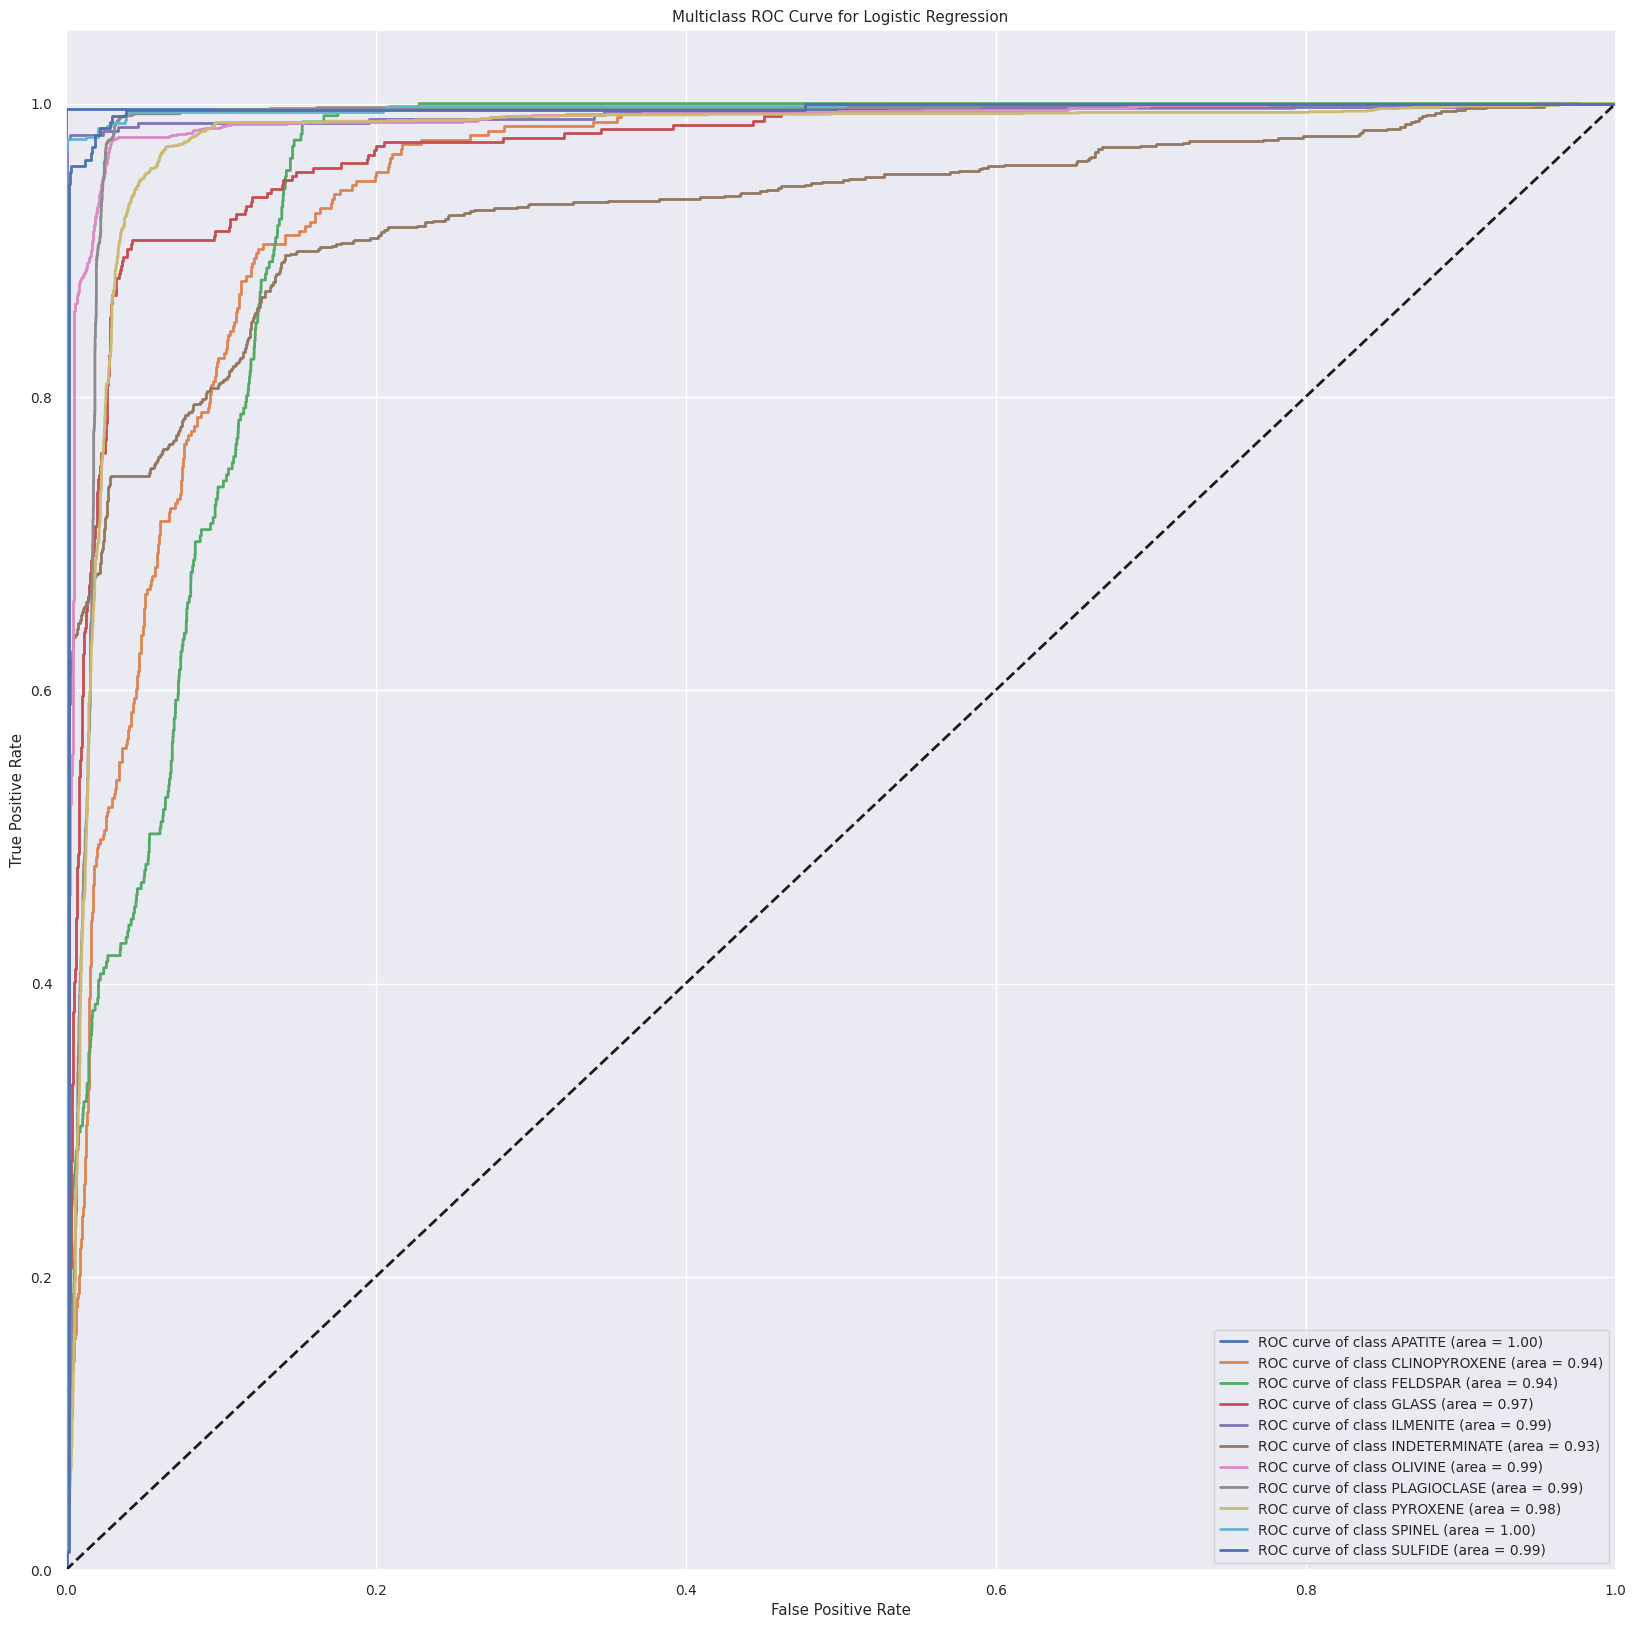

In [18]:
y_test_bin = label_binarize(y_test, classes=list(class_name_mapping.values()))

# Get predicted probabilities for each class
y_pred_proba = logreg.predict_proba(X_test)

plot_roc_curve(y_test_bin, y_pred_proba, 'Logistic Regression')

### <p style="text-align:center;"><i>Figure 6: ROC curves and AUC calculations for the Logistic Regression model</i></p>

In [19]:
display_metrics(y_test, y_pred, classes, 'Logistic Regression')


-------------------- Logistic Regression Key Metrics --------------------

Accuracy: 0.87
Balanced Accuracy: 0.73

Micro Precision: 0.87
Micro Recall: 0.87
Micro F1-score: 0.87

Macro Precision: 0.83
Macro Recall: 0.73
Macro F1-score: 0.74

Weighted Precision: 0.86
Weighted Recall: 0.87
Weighted F1-score: 0.85

--------------- Logistic Regression Classification Report ---------------

               precision    recall  f1-score   support

      APATITE       1.00      1.00      1.00       256
CLINOPYROXENE       0.52      0.04      0.07       323
     FELDSPAR       0.54      0.14      0.22       241
        GLASS       0.70      0.42      0.52       344
     ILMENITE       0.97      0.98      0.97       377
INDETERMINATE       0.92      0.64      0.75       938
      OLIVINE       0.93      0.97      0.95      2987
  PLAGIOCLASE       0.84      0.98      0.90      1440
     PYROXENE       0.79      0.98      0.87      2333
       SPINEL       0.99      0.97      0.98       532
     

## XGBoost Classifier

---

For the XGBoost classifier, I set the objective hyperparameter to softprob, as the [documentation](https://xgboost.readthedocs.io/en/stable/parameter.html) states "When used with multi-class classification, objective should be multi:softprob instead of multi:softmax, as the latter doesn’t output probability". For evaluation metrics I used merror which looks at Multiclass classification error rate and is calculated as #(wrong cases)/#(all cases). I also used the mlogloss which is the Multiclass logloss.

In [20]:
xgb_clf = xgb.XGBClassifier(objective='multi:softprob',
                            num_class=11,
                            missing=1,
                            learning_rate= 0.1,
                            eval_metric=['merror','mlogloss'],
                            seed=42)
xgb_clf.fit(X_train,
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            eval_set=[(X_train, y_train), (X_val, y_val)])



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=1,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=11, num_parallel_tree=None, ...)

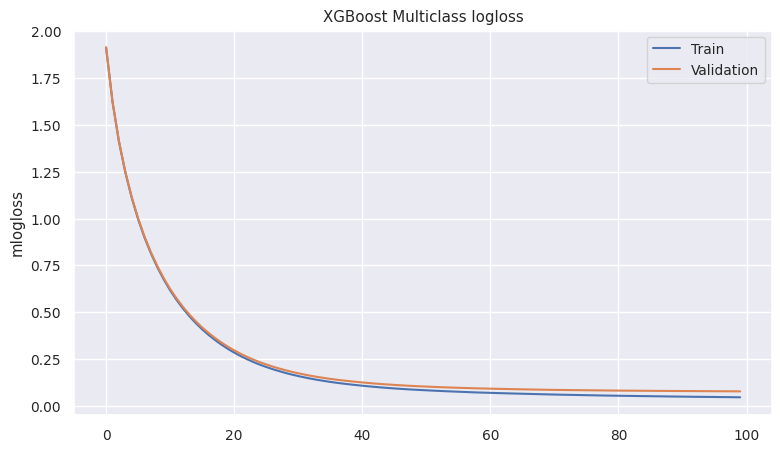

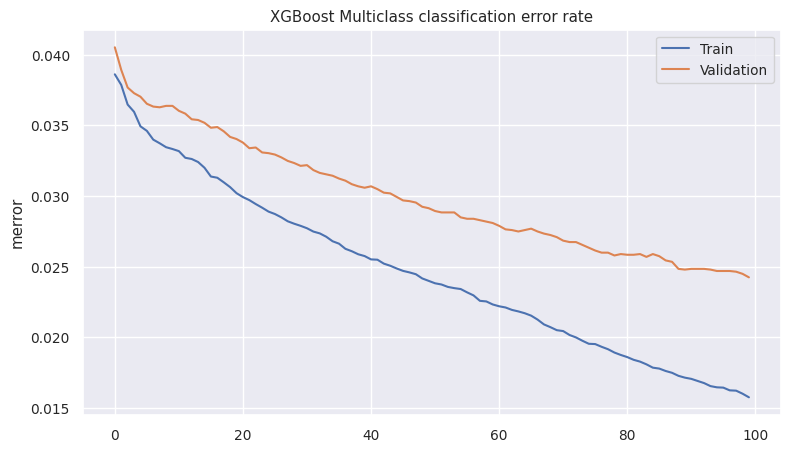

In [21]:
# preparing evaluation metric plots
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
ax.legend()
plt.ylabel('mlogloss')
plt.title('XGBoost Multiclass logloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Validation')
ax.legend()
plt.ylabel('merror')
plt.title('XGBoost Multiclass classification error rate')
plt.show()


### <p style="text-align:center;"><i>Figure 7: Logloss and Multiclass classification error rate for XGBoost training</i></p>

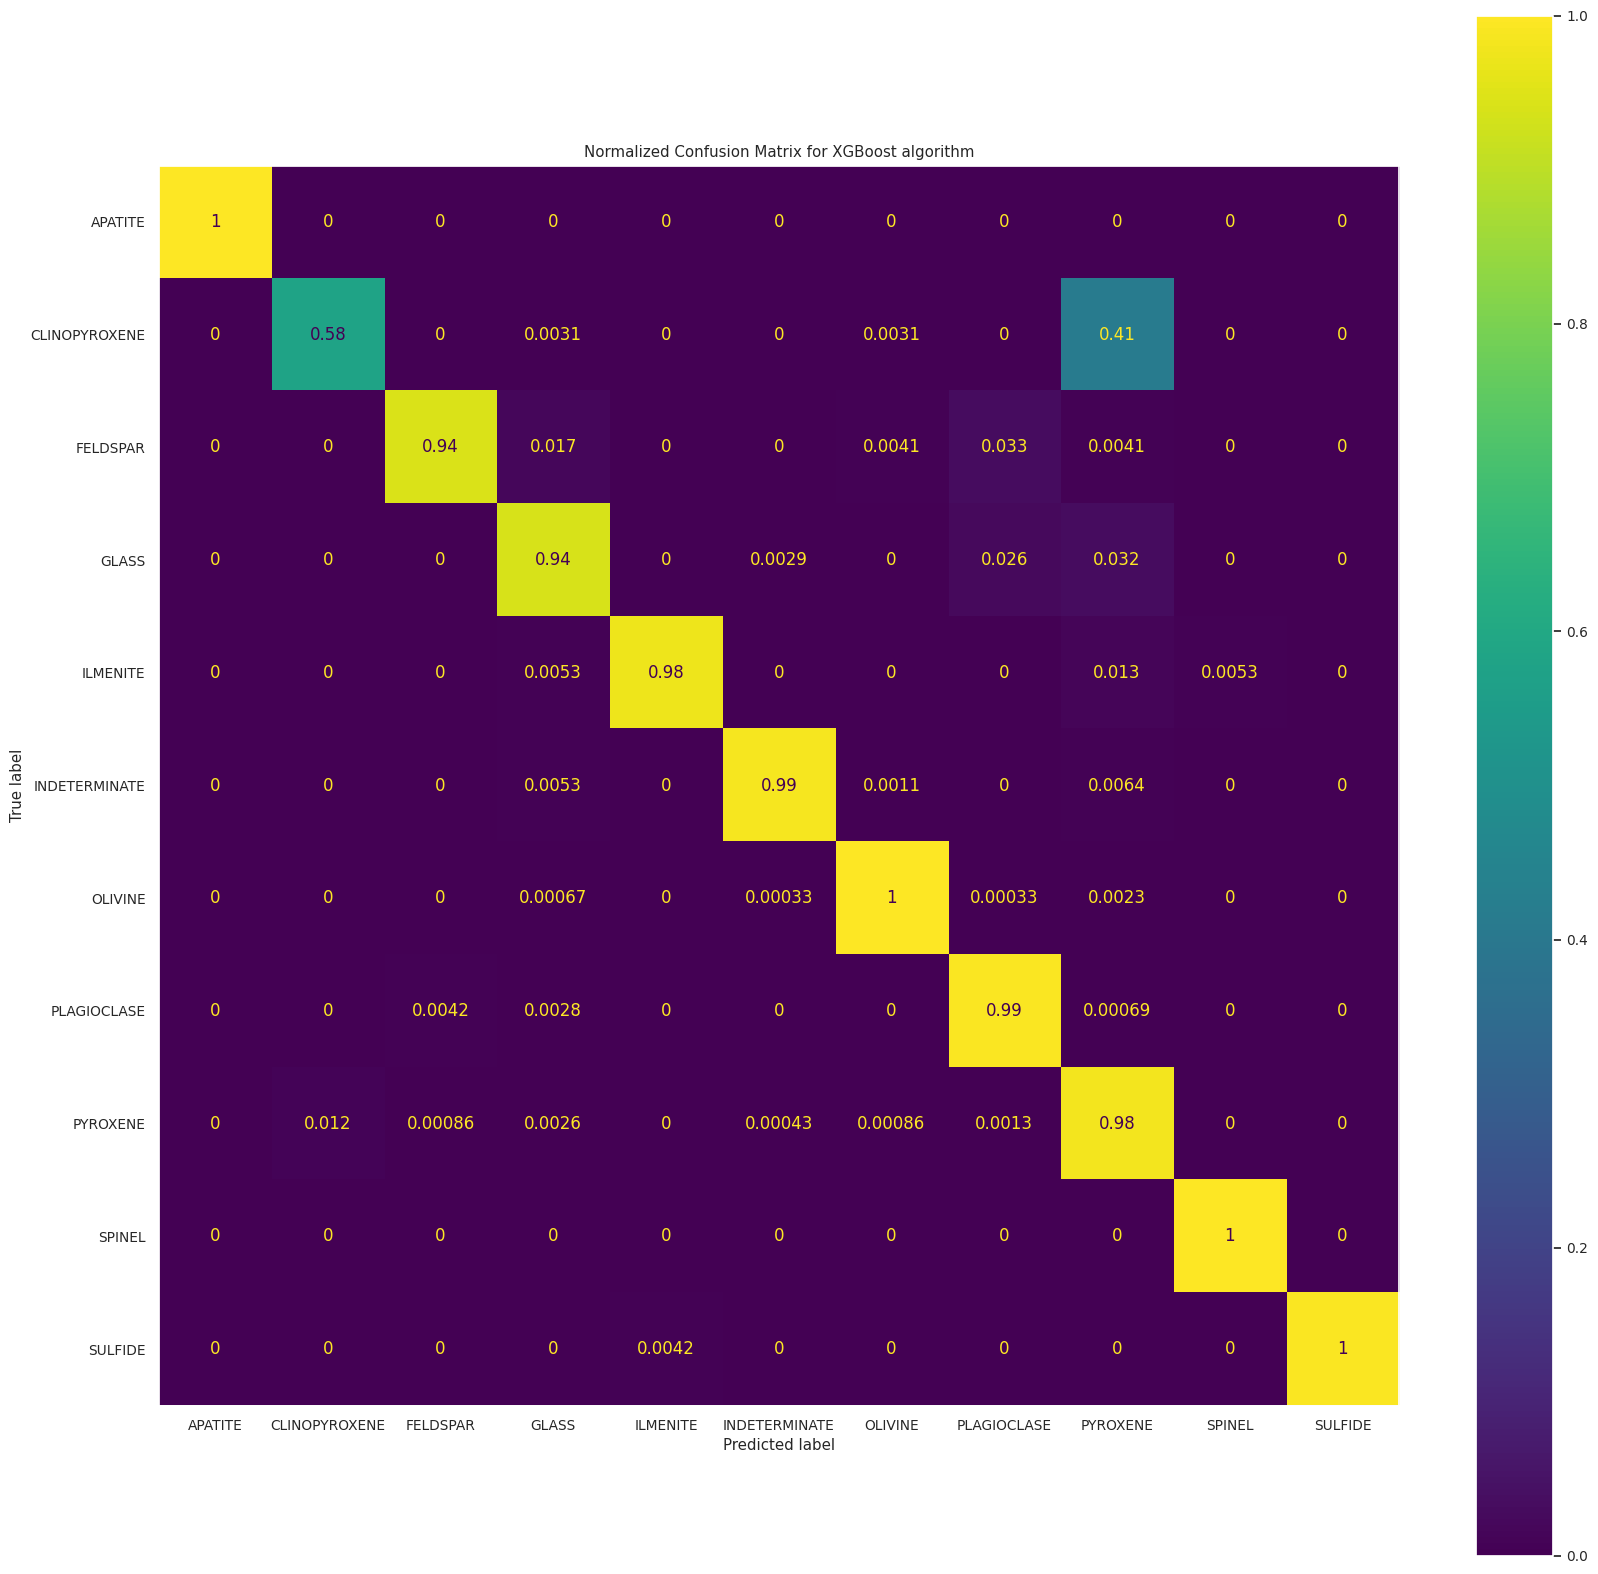

In [22]:
y_pred = xgb_clf.predict(X_test)
plot_confusion_matrix(y_test, y_pred, 'XGBoost')

### <p style="text-align:center;"><i>Figure 8: XGBoost confusion matrix. From this plot appears that the model did extremly well predicting all classes, but misclassified 40% of the clinopyroxene samples as pyroxene. Since clinopyroxene is a subtype of pyroxene, I might relabel those samples for the final submission.</i></p>

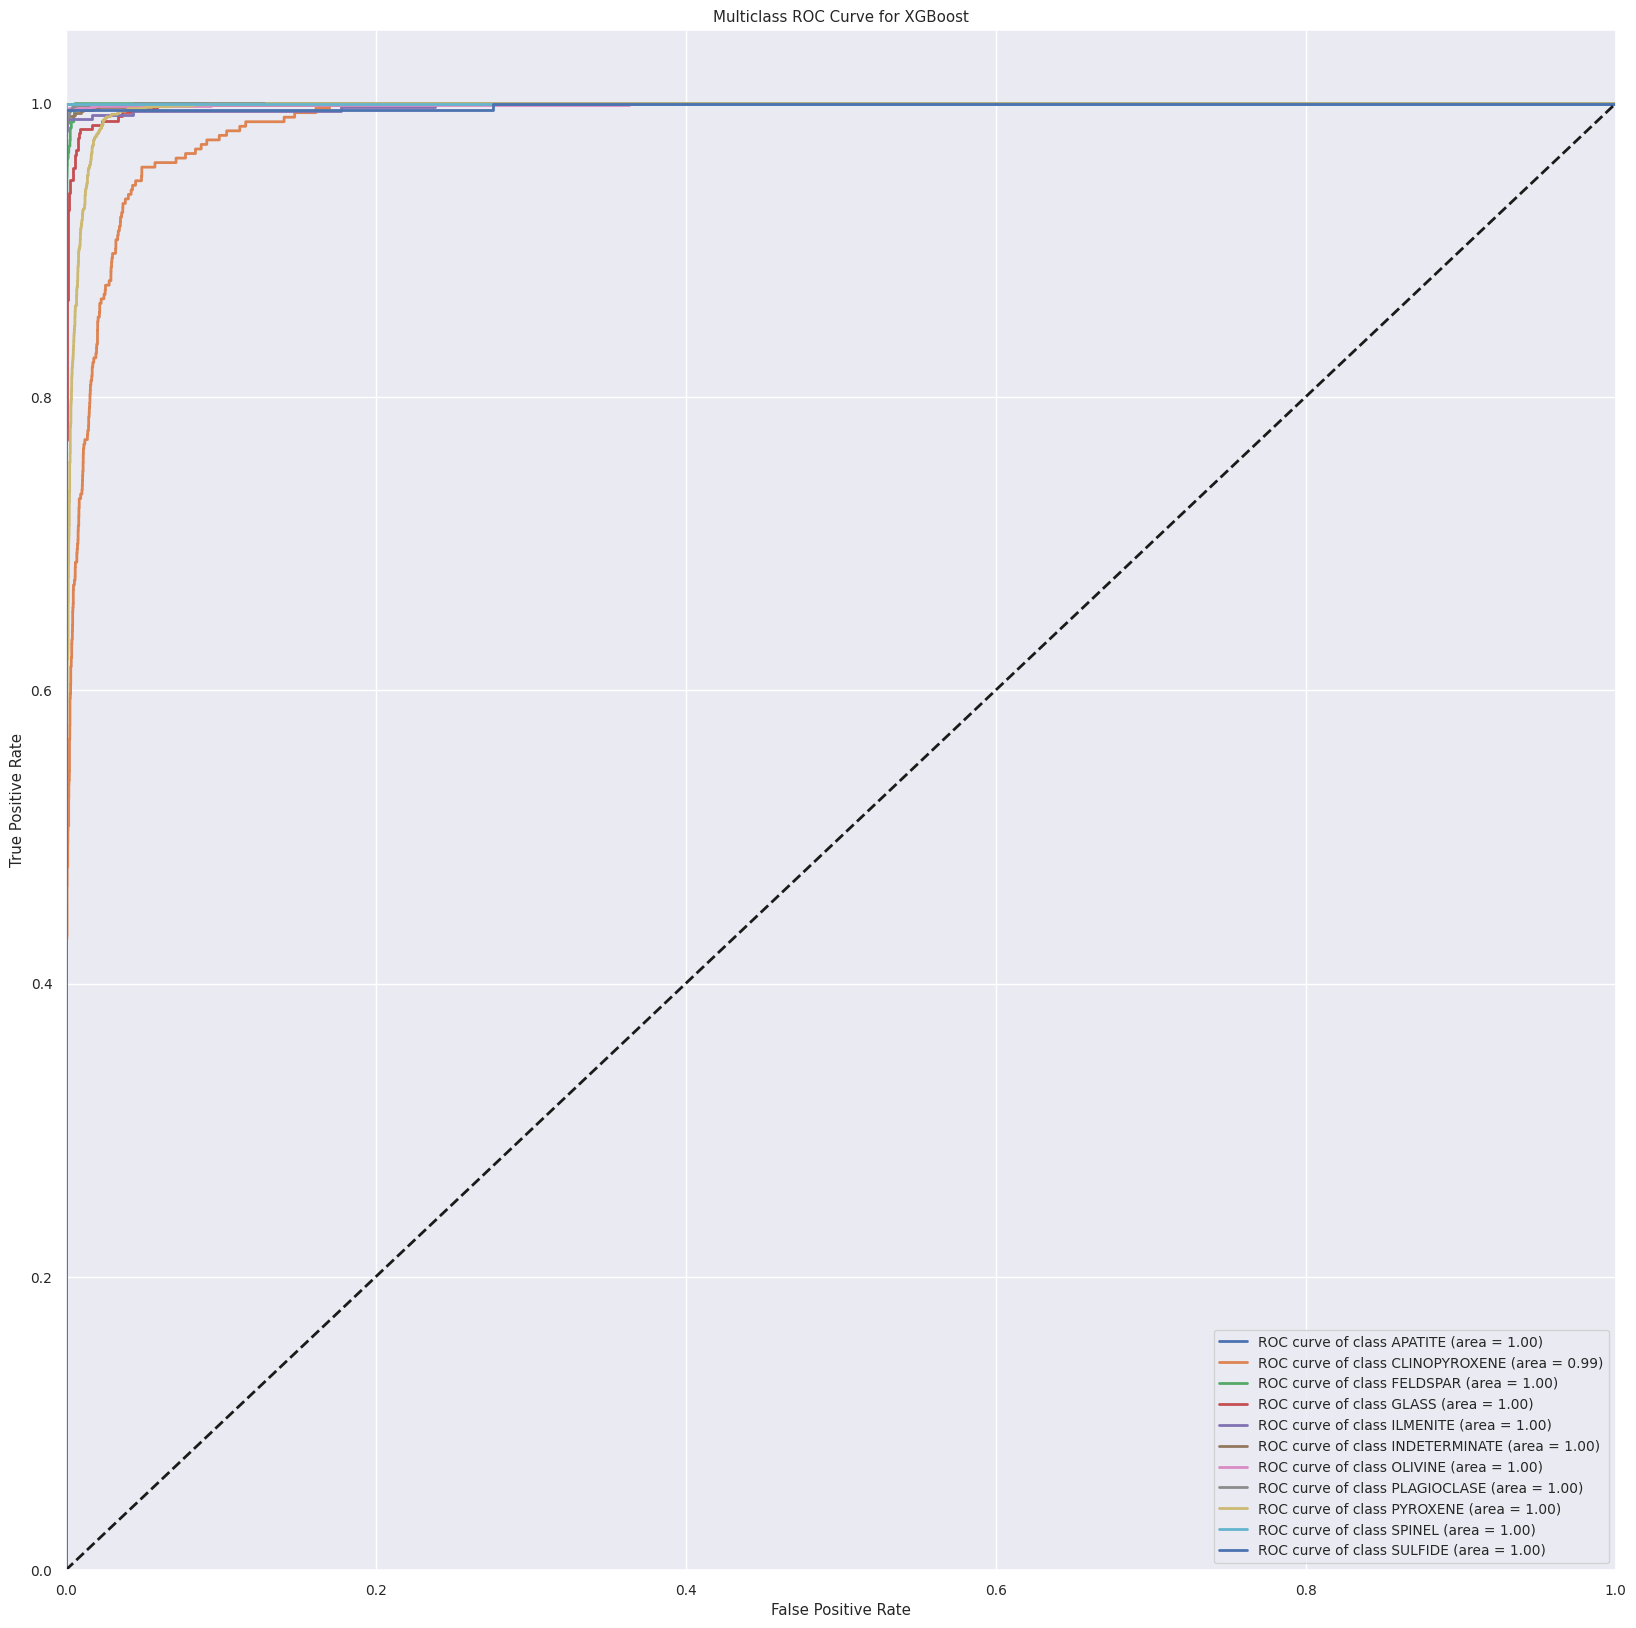

In [23]:
y_test_bin = label_binarize(y_test, classes=list(class_name_mapping.values()))

# Get predicted probabilities for each class
y_pred_proba = xgb_clf.predict_proba(X_test)

plot_roc_curve(y_test_bin, y_pred_proba, 'XGBoost')

### <p style="text-align:center;"><i>Figure 9: ROC curves and AUC calculations for the XGBoost model.</i></p>

In [24]:
display_metrics(y_test, y_pred, classes, 'XGBoost')


-------------------- XGBoost Key Metrics --------------------

Accuracy: 0.97
Balanced Accuracy: 0.94

Micro Precision: 0.97
Micro Recall: 0.97
Micro F1-score: 0.97

Macro Precision: 0.97
Macro Recall: 0.94
Macro F1-score: 0.95

Weighted Precision: 0.97
Weighted Recall: 0.97
Weighted F1-score: 0.97

--------------- XGBoost Classification Report ---------------

               precision    recall  f1-score   support

      APATITE       1.00      1.00      1.00       256
CLINOPYROXENE       0.87      0.58      0.70       323
     FELDSPAR       0.97      0.94      0.95       241
        GLASS       0.93      0.94      0.93       344
     ILMENITE       1.00      0.98      0.99       377
INDETERMINATE       1.00      0.99      0.99       938
      OLIVINE       1.00      1.00      1.00      2987
  PLAGIOCLASE       0.99      0.99      0.99      1440
     PYROXENE       0.93      0.98      0.96      2333
       SPINEL       1.00      1.00      1.00       532
      SULFIDE       1.00     

## MLP Classifier using Keras


---

I performed a split of the data again, because the neural network expects the target variable to be one-hot encoded. I also applied the scaling to the train, test and validation sets as I did before. I created a pretty shallow network, with only 3 hidden layers. I have had good luck with the Rectified Linear Unit (ReLU) activation function in the past, so I used that for the input and hidden layer, and then softmax for the output layer. I also utilized Adam as my optimizer and categorical crossentropy for the loss function as these have provided me with good results in the past with multiclass classification.

In [25]:
# Stratified split
X_train, X_temp, y_train, y_temp = train_test_split(X, y_ohe, test_size=0.3, stratify=y_ohe, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Create StratifiedShuffleSplit object
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# Perform stratified splitting
for train_index, val_index in stratified_splitter.split(X, y_ohe):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y_ohe[train_index], y_ohe[val_index]


In [26]:
#Standardize the feature vectors
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [27]:
model = Sequential()
model.add(Dense(8, activation='relu', input_shape=(8,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(11, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

In [29]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7147 - loss: 0.9325 - val_accuracy: 0.8993 - val_loss: 0.3523
Epoch 2/10
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9047 - loss: 0.3311 - val_accuracy: 0.9067 - val_loss: 0.2982
Epoch 3/10
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9156 - loss: 0.2849 - val_accuracy: 0.9141 - val_loss: 0.2868
Epoch 4/10
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9160 - loss: 0.2723 - val_accuracy: 0.9223 - val_loss: 0.2626
Epoch 5/10
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9199 - loss: 0.2633 - val_accuracy: 0.9243 - val_loss: 0.2526
Epoch 6/10
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9246 - loss: 0.2513 - val_accuracy: 0.9229 - val_loss: 0.2641
Epoch 7/10
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9268 - loss: 0.2434 - val_accuracy: 0.9294 - val_loss: 0.2448
Epoch 8/10
1460/1460 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9266 - loss: 0.2414 - 

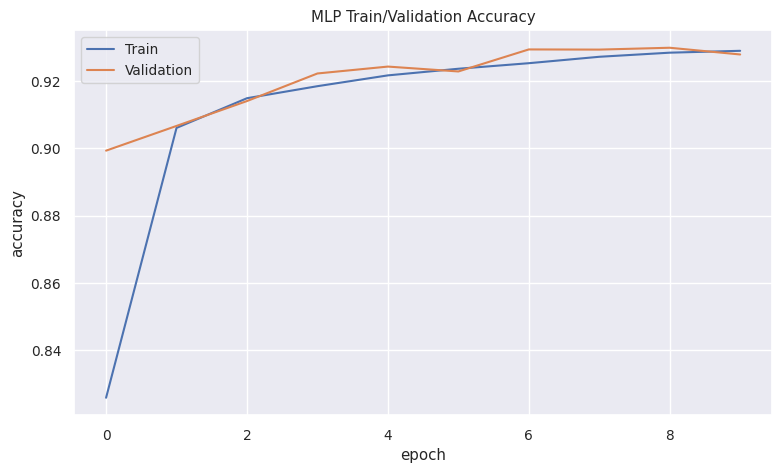

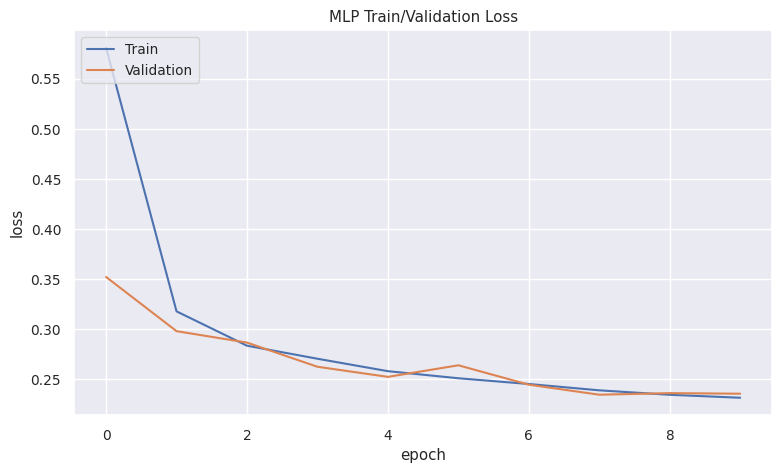

In [30]:
epochs = len(history.history['accuracy'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, history.history['accuracy'], label='Train')
ax.plot(x_axis, history.history['val_accuracy'], label='Validation')
ax.legend()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.title('MLP Train/Validation Accuracy')
plt.show()

fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, history.history['loss'], label='Train')
ax.plot(x_axis, history.history['val_loss'], label='Validation')
ax.legend()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.title('MLP Train/Validation Loss')
plt.show()

### <p style="text-align:center;"><i>Figure 10: Visual inspection of the accuracy and loss plots shows that the model may be overfitting, as the  training loss is lower than your validation loss. It appears that convergence occurs at 8 epochs. I will address this in the final submission.</i></p>

In [31]:
test_loss, test_acc = model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9266 - loss: 0.2384


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


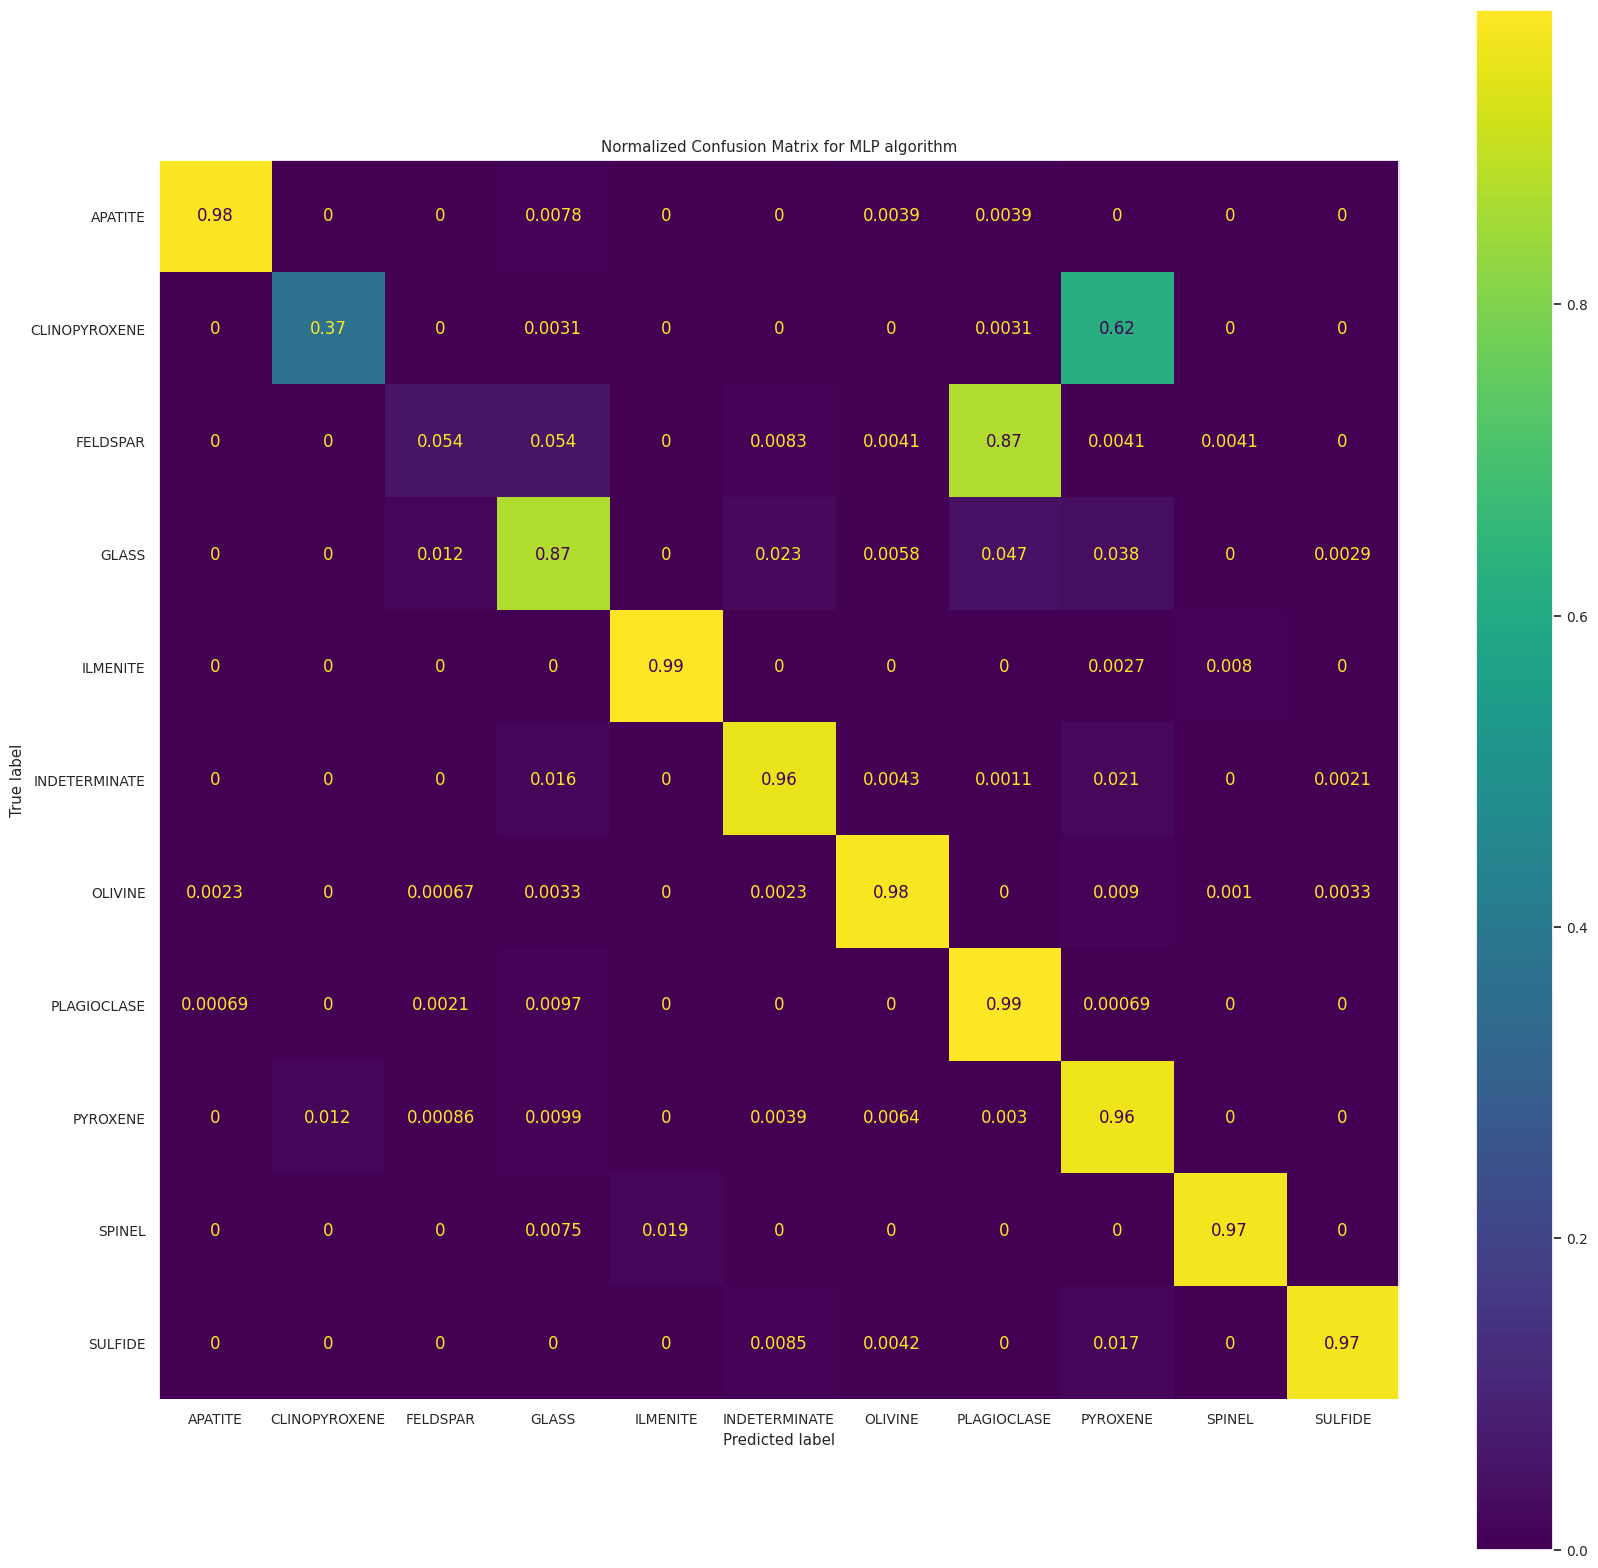

In [32]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1)
# Compute and plot the confusion matrix
plot_confusion_matrix(Y_true, Y_pred_classes, 'MLP')


### <p style="text-align:center;"><i>Figure 11: The MLP model did well, but had the same issues with Feldspar and clinopyroxene that appeared in the Logistic Regression model. There also appears to be a fair amount of misclassification of glass samples as various other types.</i></p>

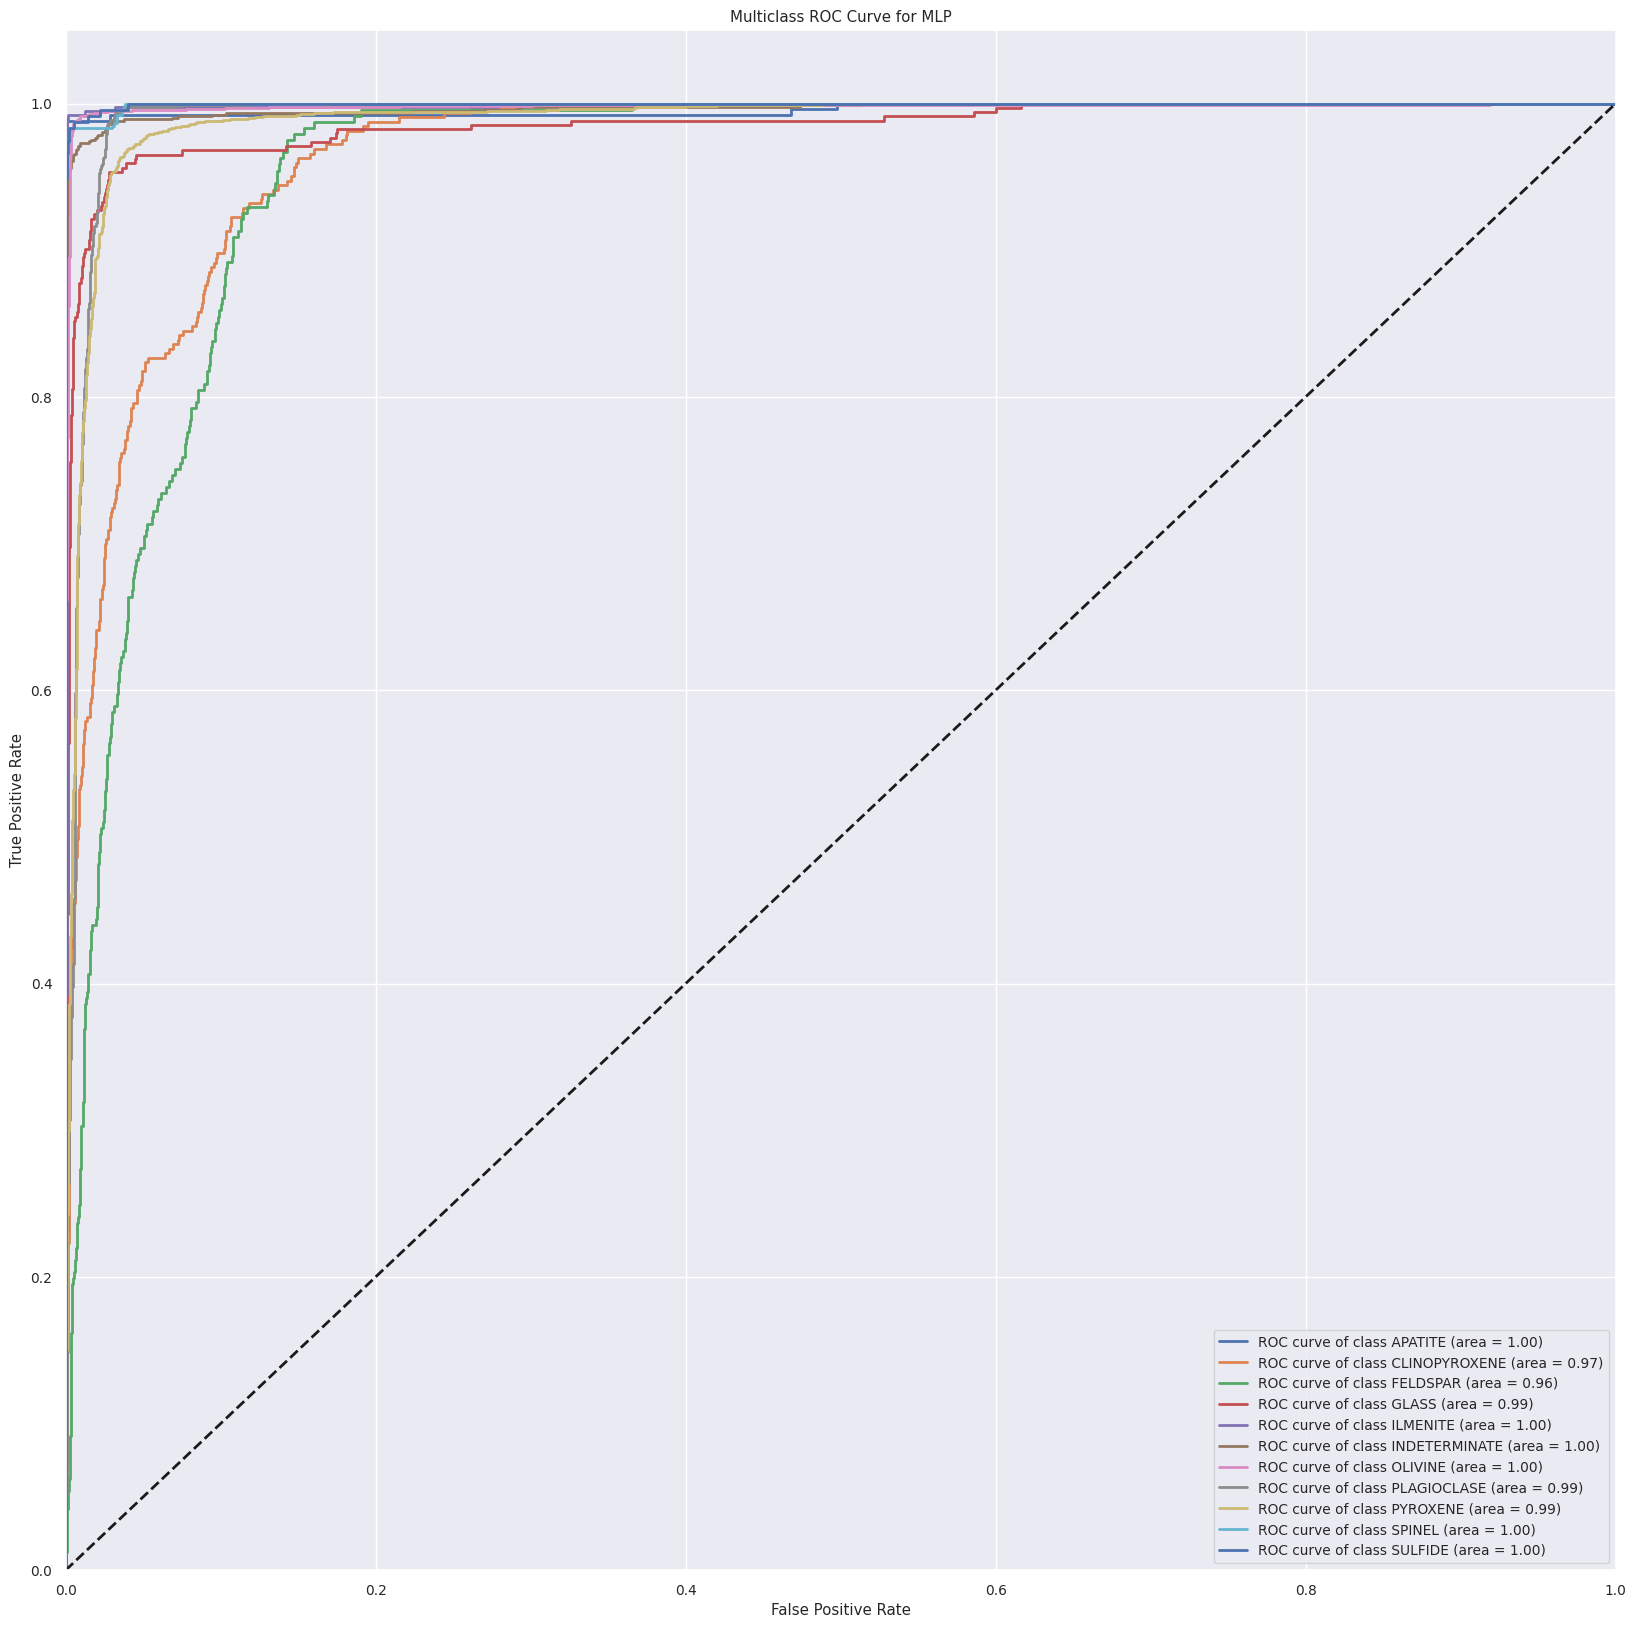

In [33]:
plot_roc_curve(y_test, Y_pred, "MLP")


### <p style="text-align:center;"><i>Figure 12: MLP ROC curves and AUC calulations.</i></p>

In [34]:
display_metrics(Y_true, Y_pred_classes, classes, 'MLP')


-------------------- MLP Key Metrics --------------------

Accuracy: 0.93
Balanced Accuracy: 0.83

Micro Precision: 0.93
Micro Recall: 0.93
Micro F1-score: 0.93

Macro Precision: 0.88
Macro Recall: 0.83
Macro F1-score: 0.83

Weighted Precision: 0.92
Weighted Recall: 0.93
Weighted F1-score: 0.92

--------------- MLP Classification Report ---------------

               precision    recall  f1-score   support

      APATITE       0.97      0.98      0.98       256
CLINOPYROXENE       0.81      0.37      0.51       323
     FELDSPAR       0.54      0.05      0.10       241
        GLASS       0.79      0.87      0.83       344
     ILMENITE       0.97      0.99      0.98       377
INDETERMINATE       0.97      0.96      0.96       938
      OLIVINE       0.99      0.98      0.98      2987
  PLAGIOCLASE       0.86      0.99      0.92      1440
     PYROXENE       0.89      0.96      0.93      2333
       SPINEL       0.99      0.97      0.98       532
      SULFIDE       0.95      0.97   

- **Which method did you like the most?**
#### From a results, ease of use and explainability standpoint, I liked XGBoost the most. I have taken an  NVIDIA training course that used XGBoost for Anomaly Detection, but getting to utilize it with a dataset of my choosing for classification was cool and I was very happy with the results of this algorithm.
- **Which method did you like the least?**
#### Logistic Regression gave the worst results, so this is the reason why I liked this algorithm the least. I also had a hard time determining how to capture the loss and accuracy for each epoch of the Logistic Regression training.

- **How did you score these supervised models?**
#### To score these algorithm I used confusion matrices, ROC/AUC curves, and classification reports.

- **Did the output align with your geologic understanding?**
#### As I don't have a strong background in geology, I had to do some research to determine information about minerals. I discovered that clinopyroxene is a specific type of pyroxene, which I believe is the reason that those samples are being misclassified. I also found out that plagioclase is a type of feldspar, which appeared to be misclassified by the neural network. Becuase of these misclassifications, I think the proper course of action is to combine the clinopyroxene and pyroxene samples as well as the plagioclase and felspar samples under one label.
- **Did you hyperparameter tune? Why or why not?**
#### I actually got really good results without much hyperparameter tuning, so I didn't really attempt to tune hyperparameters
- **How did you split your data? and why does that make sense for this dataset?**
#### Because of the class imbalance that exisits in the data, I performed a Stratified Split of the data. I believe this was a good method to choose, as stratified splitting is important to maintain a consistent class distribution across training, validation, and test sets.
- **What did you want to learn more about?**
#### I didn't really look into the hyperparameters for Logistic Regression, so I just used the "vanilla" algorithm. For the final submission I might look into what knobs I can turn from a hyperparameter standpoint to improve model performance.
- **Did you pre-process your data?**
#### I did a fair amount of pre-processing during EDA including dropping rows with NAN's and converting the data to tehe correct data type. In this notebook I encoded the classes using a label encoder and then one-hot encoded the class targets for the neural network. I also fit a standard scaler to the training data and then transformed the validation and test sets with the same scaler that was fit to the training data to prevent introducing bias.
- **Do all models require pre-processing?**
#### Yes, all the models require pre-processing, as the target variables need to be converted to integers in order to perform model training.